The goal here is to read in the 4MOST/TiDES healpix list (4MOST_healpix.csv) and reproduce the footprint from the 4MOST team. The final pixel list is saved in `/global/homes/a/awan/desc/4most_desi_data/`.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pylab
import healpy as hp
import numpy as np
import pandas as pd

from astropy.coordinates import SkyCoord
from astropy import units as u

import healpy as hp
import pandas as pd
import numpy as np

In [3]:
fontsize = 16
pylab.rcParams['figure.figsize'] = (10, 6)
pylab.rcParams['axes.labelsize'] = fontsize
pylab.rcParams['xtick.labelsize'] = fontsize-2
pylab.rcParams['ytick.labelsize'] = fontsize-2
pylab.rcParams['legend.fontsize'] = fontsize

**Set up some things**

In [4]:
# 4most data characteristics
nside = 256
nest = True # the pixels are for nested order
order = 'NESTED'  # needed for mollview plot

# paths
data_dir = '/global/homes/a/awan/desc/4most-tides_desi_data/'
filepath = '%s4MOST_healpix.csv'%data_dir

**First lets try creating the mollview map -- don't need to convert the HEALPix numbers to ra, dec.**

## Reading in /global/homes/a/awan/desc/4most-tides_desi_data/4MOST_healpix.csv


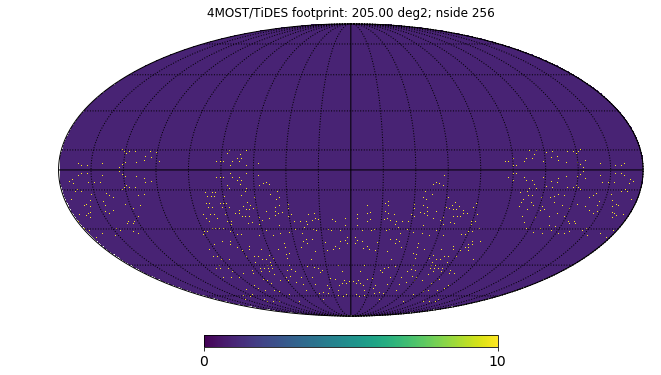

## Changing Nside 256 to Nside 16


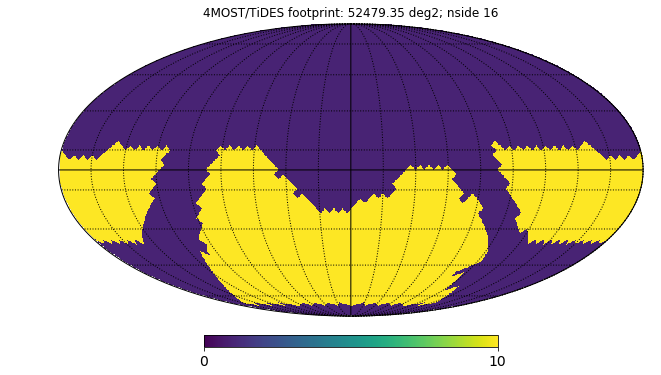

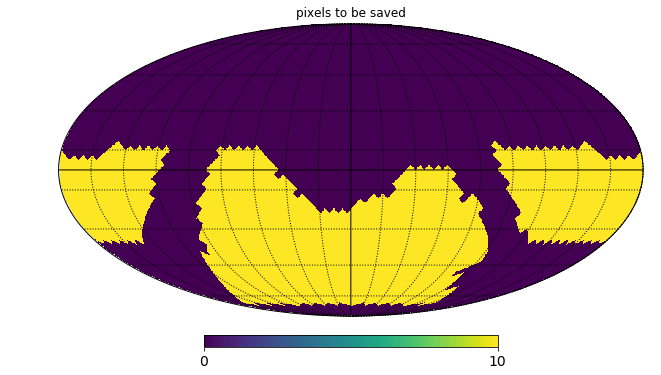

In [5]:
print('## Reading in %s'%filepath)
data = pd.read_csv(filepath)
# extract the pixel numbers
hp_pix = [int(f) for f in data['# hid']]

# set up the skymaps
nPix = hp.nside2npix(nside)
vals = np.zeros(nPix)+1.  # initiate all data to 1
vals[hp_pix] = 5000   # add fake data to the pixels in our list

# plot the skymap
plt.clf()
title = '4MOST/TiDES footprint: %.2f deg2'%(len(hp_pix)*hp.nside2pixarea(nside=nside,
                                                                         degrees=True))
title += '; nside %s'%(nside)
hp.mollview(vals, flip='astro', rot=(0,0,0), min=0, max=10, nest=nest,
            title= title
           )
hp.graticule(dpar=20, dmer=20, verbose=False)
plt.show()

# degrade the skymap see continuous footprint
nside_4most = 2**4  # chosen so that we have continuous area
print('## Changing Nside %s to Nside %s'%(nside, nside_4most))
four_most_footprint = hp.ud_grade(vals, nside_out=nside_4most, order_in=order, order_out=order)

plt.clf()
title = '4MOST/TiDES footprint: %.2f deg2'%(len(np.where(vals>10)[0])* \
                                            hp.nside2pixarea(nside=nside_4most,
                                                             degrees=True))
title += '; nside %s'%(nside_4most)

hp.mollview(four_most_footprint, flip='astro', rot=(0,0,0), min=0, max=10, nest=nest,
            title=title,
           )
hp.graticule(dpar=20, dmer=20, verbose=False)
plt.show()

# keep the pixels for saving purposes. lets just plot things to be sure.
pix_to_keep = np.where(four_most_footprint>5)[0]
pix_to_keep = hp.nest2ring(ipix=pix_to_keep, nside=nside_4most)  # change to ring ordering
vals = np.zeros(hp.nside2npix(nside_4most))
vals[pix_to_keep] = 100
hp.mollview(vals, flip='astro', rot=(0,0,0), min=0, max=10,
            title='pixels to be saved'
           )
hp.graticule(dpar=20, dmer=20, verbose=False)

**Okay, now lets create the mollweide skymap to using matplotlib see if we recover the healpix skymap**

We use hp.pix2ang to get latitude, longitude corresponding to each pixel number. Then, pixel dec = np.pi/2 - latitude and ra = longitude.

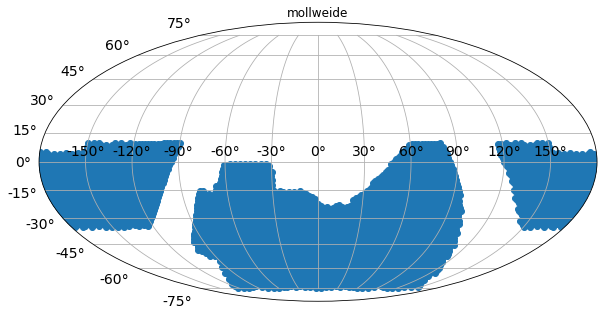

In [6]:
plt.figure()
plt.subplot(111, projection="mollweide")
lat, ra = hp.pix2ang(ipix=hp_pix, nside=nside, nest=True)
dec = np.pi/2.0 - lat
c = SkyCoord(ra=ra * u.radian, dec=dec * u.radian, frame='icrs')
ra_rad = c.ra.wrap_at(180. * u.deg).radian
dec_rad = c.dec.radian
plt.scatter(ra_rad, dec_rad)
plt.title("mollweide")
plt.grid(True)
plt.show()

Okay this matches with our healpy skymaps (after correcting for the RA directions being opposite).

**Okay, now lets create the aitoff skymap to using matplotlib see if we recover the footprint from the 4MOST team:**

<img src="4most_field_visits.png"
     alt="Markdown Monster icon"
     style="float: center; margin-right: 10px;" width="900" height="900" />

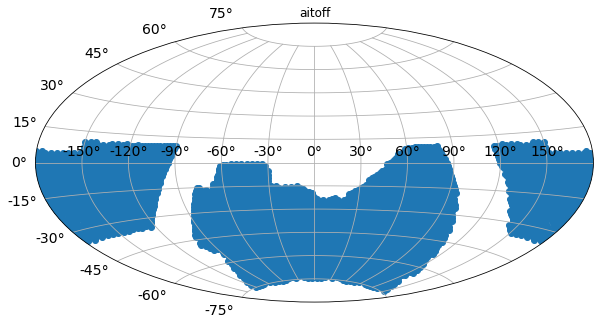

In [7]:
plt.figure()
plt.subplot(111, projection="aitoff")
lat, ra = hp.pix2ang(ipix=hp_pix, nside=nside, nest=True)
dec = np.pi/2.0 - lat
c = SkyCoord(ra=ra * u.radian, dec=dec * u.radian, frame='icrs')
ra_rad = c.ra.wrap_at(180. * u.deg).radian
dec_rad = c.dec.radian
plt.scatter(ra_rad, dec_rad)
plt.title("aitoff")
xticks = plt.gca().get_xticks()
plt.grid(True)
plt.show()

Hm this looks okay (after accounting for the fact that we have 0h at the center).

**Save the data**

In [8]:
filename = '4MOST-TiDES_pixels_nside%s_ring.csv'%nside_4most
pd.DataFrame({'pixNum': pix_to_keep}).to_csv('%s/%s'%(data_dir, filename), index=False)
print('Saved %s in %s'%(filename, data_dir))

Saved 4MOST-TiDES_pixels_nside16_ring.csv in /global/homes/a/awan/desc/4most-tides_desi_data/
